In [1]:
import pandas as pd
import numpy as np
import multiprocessing
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model

In [2]:
rules = pd.read_csv("test-recommend-output-wocDepSeq3-all.csv")
to_lib2max_freq = {to_lib: max(row["ruleFreqSameCommit"]) for to_lib, row in rules.groupby(by="toLib")}
rules["ruleFreqToLibSameCommit"] = rules["ruleFreqSameCommit"] / rules["toLib"].apply(lambda x: to_lib2max_freq[x])
rules.insert(4, "confTeyton", np.minimum(rules["ruleFreqSameCommit"], rules["ruleFreqToLibSameCommit"]).fillna(0))
# to_lib2max_freq = {to_lib: max(row["ruleFreq"]) for to_lib, row in rules.groupby(by="toLib")}
# rules["ruleFreqToLib"] = rules["ruleFreq"] / rules["toLib"].apply(lambda x: to_lib2max_freq[x])
# rules["popularityRegularization"] = rules["ruleFreq"] * rules["concurrenceAdjustment"]
# from_lib2max_count = {from_lib: max(row["possibleCommitCount"]) for from_lib, row in rules.groupby(by="fromLib")}
# rules["commitMessageSupport"] = [x / (from_lib2max_count[from_lib] + 1) for from_lib, x in zip(rules["fromLib"], rules["possibleCommitCount"])]

In [3]:
from_libs = set()
with open("from-lib-confirmed.txt", "r") as f:
    from_libs = set(x.strip() for x in f)
len(from_libs), len(from_libs - set(rules["fromLib"]))

(195, 1)

In [4]:
import2vecs = dict()
with open("../embedding/java_w2v_dim100.txt", "r") as f:
    num_lib, num_dim = tuple(f.readline().split(" "))
    num_lib, num_dim = int(num_lib), int(num_dim)
    for line in f:
        vals = line.split(" ")
        import2vecs[vals[0]] = [float(x) for x in vals[1:]]
similarities = []
for f, t in zip(rules["fromLib"], rules["toLib"]):
    if f in import2vecs and t in import2vecs:
        similarities.append(
            np.dot(import2vecs[f], import2vecs[t]) 
            / (np.linalg.norm(import2vecs[f]) * np.linalg.norm(import2vecs[t])))
    else:
        similarities.append(0)
rules["similarity"] = similarities
print(len(rules[rules["similarity"] != 0]))

115026


In [5]:
ground_truth = pd.read_excel("manual/ground-truth.xlsx")
rules_existed = set(zip(rules["fromLib"], rules["toLib"]))
confirmed_rule_set = set(zip(
    ground_truth[ground_truth["isConfirmed"]]["fromLib"], 
    ground_truth[ground_truth["isConfirmed"]]["toLib"]
)) & rules_existed
possible_rule_set = (set(zip(
    ground_truth[ground_truth["ruleCount"] > 0]["fromLib"], 
    ground_truth[ground_truth["ruleCount"] > 0]["toLib"]
)) | confirmed_rule_set) & rules_existed

rules["isPossible"] = [x in possible_rule_set for x in zip(rules["fromLib"], rules["toLib"])]
rules.insert(2, "isConfirmed", [x in confirmed_rule_set for x in zip(rules["fromLib"], rules["toLib"])])
possible_rules = rules[rules["isPossible"]]
confirmed_rules = rules[rules["isConfirmed"]]
other_rules = rules[~rules["isConfirmed"] & ~rules["isPossible"]]
print("# rules = {}, # confirmed = {}, # possible = {}, # confirmed from libs = {}".format(
    len(rules), len(confirmed_rule_set), len(possible_rule_set), 
    len(set(x[0] for x in confirmed_rule_set))
))

# rules = 243152, # confirmed = 773, # possible = 1446, # confirmed from libs = 190


In [6]:
def evaluate(method, rules, possible_rules, confirmed_rules):
    top_k = 100
    top_rules = [list() for x in range(0, top_k)]
    ndcg_possible_at_k = [list() for x in range(0, top_k)]
    ndcg_confirmed_at_k = [list() for x in range(0, top_k)]
    from_lib_set = set(x for x, y in confirmed_rules)
    reciprocal_ranks_confirmed = {}
    reciprocal_ranks_possible = {}
    for from_lib, candidates in rules.groupby(by="fromLib"):
        if from_lib not in from_lib_set:
            continue
        this_rules = [(from_lib, to_lib) for to_lib in candidates["toLib"]]
        this_possible_rules = [(from_lib, to_lib) for from_lib, to_lib in this_rules if (from_lib, to_lib) in possible_rules]
        this_confirmed_rules = [(from_lib, to_lib) for from_lib, to_lib in this_rules if (from_lib, to_lib) in confirmed_rules]
        for k, (from_lib, to_lib) in enumerate(this_rules):
            if k >= top_k:
                continue
            top_rules[k].append((from_lib, to_lib))
            if (from_lib, to_lib) in possible_rules and from_lib not in reciprocal_ranks_possible:
                reciprocal_ranks_possible[from_lib] = 1 / (k + 1)
            if (from_lib, to_lib) in confirmed_rules and from_lib not in reciprocal_ranks_confirmed:
                reciprocal_ranks_confirmed[from_lib] = 1 / (k + 1)
            dcg_p = sum(int((from_lib, to_lib) in possible_rules) / np.log2(i+2) for i, (from_lib, to_lib) in enumerate(this_rules[0:k+1]))
            idcg_p = sum(1 / np.log2(i+2) for i in range(0, min(k + 1, len(this_possible_rules))))
            ndcg_possible_at_k[k].append(dcg_p / idcg_p)
            dcg_c = sum(int((from_lib, to_lib) in confirmed_rules) / np.log2(i+2) for i, (from_lib, to_lib) in enumerate(this_rules[0:k+1]))
            idcg_c = sum(1 / np.log2(i+2) for i in range(0, min(k + 1, len(this_confirmed_rules))))
            ndcg_confirmed_at_k[k].append(dcg_c / idcg_c)
        if from_lib not in reciprocal_ranks_possible:
            reciprocal_ranks_possible[from_lib] = 0
        if from_lib not in reciprocal_ranks_confirmed:
            reciprocal_ranks_confirmed[from_lib] = 0
    for k in range(1, top_k):
        top_rules[k] += top_rules[k - 1] 
    result = {
        "Name": method,
        "FromLibCount": len(from_lib_set & set(rules["fromLib"])),
        "MRR-C": np.mean(list(reciprocal_ranks_confirmed.values())),
        "MRR-P": np.mean(list(reciprocal_ranks_possible.values())),
        "Precision-C@k": [],
        "Precision-P@k": [],
        "Recall-C@k": [],
        "Recall-P@k": [],
        "NDCG-C@k": [],
        "NDCG-P@k": [],
    }
    for k in range(0, top_k):
        precision = len([x for x in top_rules[k] if x in confirmed_rules]) / len(top_rules[k])
        recall = len([x for x in top_rules[k] if x in confirmed_rules]) / len(confirmed_rules)
        precision_possible = len([x for x in top_rules[k] if x in possible_rules]) / len(top_rules[k])
        recall_possible = len([x for x in top_rules[k] if x in possible_rules]) / len(possible_rules)
        result["Precision-C@k"].append(precision)
        result["Precision-P@k"].append(precision_possible)
        result["Recall-C@k"].append(recall)
        result["Recall-P@k"].append(recall_possible)
        result["NDCG-C@k"].append(np.mean(ndcg_confirmed_at_k[k]))
        result["NDCG-P@k"].append(np.mean(ndcg_possible_at_k[k]))
    return result
def print_evaluation_result(result):
    print("Result of {} on {} Library Queries:".format(result["Name"], result["FromLibCount"]))
    print("MRR-C/P = {}/{}".format(result["MRR-C"], result["MRR-P"]))
    for k in range(0, len(result["Precision-C@k"])):
        if k + 1 > 10 and (k + 1) % 10 != 0:
            continue
        print("Top {:3}: Precision-C/P = {:0.3f}/{:0.3f}, Recall-C/P = {:0.3f}/{:0.3f}, NDCG-C/P = {:0.3f}/{:0.3f}"
              .format(k + 1, 
                      result["Precision-C@k"][k],
                      result["Precision-P@k"][k],
                      result["Recall-C@k"][k],
                      result["Recall-P@k"][k],
                      result["NDCG-C@k"][k], 
                      result["NDCG-P@k"][k]))
def print_one_line_evaluation_result(result):
    print("{:30}: Precision@1 = {:0.3f}, MRR = {:0.3f}, Recall@5 = {:0.3f}, Recall@10 = {:0.3f}, "
         "Recall@20 = {:0.3f}, NDCG@10 = {:0.3f}".format(
             result["Name"],
             result["Precision-C@k"][0],
             result["MRR-C"],
             result["Recall-C@k"][4],
             result["Recall-C@k"][9],
             result["Recall-C@k"][19],
             result["NDCG-C@k"][9]
         ))

In [7]:
def our_method(rules):
    rules["confidence"] = (
        # np.minimum(0.15, rules["confTeyton"])
        # np.log2(rules["confTeyton"] + 1)
        rules["confTeyton"]
        # * rules["ruleFreq"]
        # * rules["ruleCount"] / rules["concurrence"]
        # * rules["concurrenceAdjustment"]
        # * np.minimum(rules["ruleFreq"], rules["ruleFreqToLib"])
        * np.maximum(0.1, rules["apiSupport"])
        # * rules["positionSupport"] 
        * rules["commitDistance"]
        * np.log2(rules["possibleCommitCount"] + 1)
        # * np.maximum(0.2, rules["commitMessageSupport"])
        # * np.minimum(rules["similarity"], 0.1)
    )
    return rules.sort_values(by=["fromLib", "confidence"], ascending=[True, False])
result = evaluate("Our Method", our_method(rules), possible_rule_set, confirmed_rule_set)
print_evaluation_result(result)
our_method(rules).to_csv("recommend-output.csv", index=False)

Result of Our Method on 190 Library Queries:
MRR-C/P = 0.8565813287461487/0.8565813287461487
Top   1: Precision-C/P = 0.795/0.795, Recall-C/P = 0.195/0.104, NDCG-C/P = 0.795/0.795
Top   2: Precision-C/P = 0.661/0.664, Recall-C/P = 0.323/0.174, NDCG-C/P = 0.781/0.740
Top   3: Precision-C/P = 0.558/0.564, Recall-C/P = 0.409/0.221, NDCG-C/P = 0.764/0.694
Top   4: Precision-C/P = 0.491/0.499, Recall-C/P = 0.479/0.260, NDCG-C/P = 0.761/0.667
Top   5: Precision-C/P = 0.437/0.447, Recall-C/P = 0.533/0.291, NDCG-C/P = 0.759/0.647
Top   6: Precision-C/P = 0.391/0.400, Recall-C/P = 0.572/0.313, NDCG-C/P = 0.755/0.627
Top   7: Precision-C/P = 0.358/0.367, Recall-C/P = 0.611/0.334, NDCG-C/P = 0.756/0.613
Top   8: Precision-C/P = 0.335/0.343, Recall-C/P = 0.652/0.357, NDCG-C/P = 0.760/0.607
Top   9: Precision-C/P = 0.315/0.322, Recall-C/P = 0.688/0.377, NDCG-C/P = 0.765/0.603
Top  10: Precision-C/P = 0.292/0.300, Recall-C/P = 0.709/0.389, NDCG-C/P = 0.767/0.599
Top  20: Precision-C/P = 0.185/0.194,

In [8]:
def teyton_2013(rules):
    return rules.sample(frac=1).sort_values(by=["fromLib", "confTeyton"], ascending=[True, False])
result = evaluate("Teyton et al. 2013", teyton_2013(rules), possible_rule_set, confirmed_rule_set)
print_evaluation_result(result)

Result of Teyton et al. 2013 on 190 Library Queries:
MRR-C/P = 0.7257657912753291/0.7309045267080756
Top   1: Precision-C/P = 0.658/0.663, Recall-C/P = 0.162/0.087, NDCG-C/P = 0.658/0.663
Top   2: Precision-C/P = 0.495/0.511, Recall-C/P = 0.242/0.133, NDCG-C/P = 0.601/0.580
Top   3: Precision-C/P = 0.420/0.438, Recall-C/P = 0.308/0.172, NDCG-C/P = 0.590/0.547
Top   4: Precision-C/P = 0.378/0.394, Recall-C/P = 0.369/0.205, NDCG-C/P = 0.589/0.529
Top   5: Precision-C/P = 0.332/0.352, Recall-C/P = 0.405/0.230, NDCG-C/P = 0.580/0.511
Top   6: Precision-C/P = 0.311/0.329, Recall-C/P = 0.454/0.257, NDCG-C/P = 0.584/0.504
Top   7: Precision-C/P = 0.289/0.306, Recall-C/P = 0.493/0.279, NDCG-C/P = 0.586/0.492
Top   8: Precision-C/P = 0.271/0.291, Recall-C/P = 0.528/0.303, NDCG-C/P = 0.592/0.492
Top   9: Precision-C/P = 0.253/0.273, Recall-C/P = 0.554/0.319, NDCG-C/P = 0.593/0.487
Top  10: Precision-C/P = 0.238/0.256, Recall-C/P = 0.578/0.333, NDCG-C/P = 0.597/0.482
Top  20: Precision-C/P = 0.14

In [9]:
def teyton_2014(rules):
    return rules.sample(frac=1).sort_values(by=["fromLib", "ruleFreq"], ascending=[True, False])
result = evaluate("Teyton et al. 2014", teyton_2014(rules), possible_rule_set, confirmed_rule_set)
print_evaluation_result(result)

Result of Teyton et al. 2014 on 190 Library Queries:
MRR-C/P = 0.5210146449020914/0.5475251522983586
Top   1: Precision-C/P = 0.432/0.453, Recall-C/P = 0.106/0.059, NDCG-C/P = 0.432/0.453
Top   2: Precision-C/P = 0.312/0.328, Recall-C/P = 0.153/0.086, NDCG-C/P = 0.381/0.378
Top   3: Precision-C/P = 0.256/0.277, Recall-C/P = 0.188/0.109, NDCG-C/P = 0.369/0.356
Top   4: Precision-C/P = 0.214/0.235, Recall-C/P = 0.208/0.122, NDCG-C/P = 0.358/0.334
Top   5: Precision-C/P = 0.180/0.202, Recall-C/P = 0.220/0.131, NDCG-C/P = 0.347/0.316
Top   6: Precision-C/P = 0.162/0.185, Recall-C/P = 0.237/0.145, NDCG-C/P = 0.345/0.310
Top   7: Precision-C/P = 0.147/0.169, Recall-C/P = 0.250/0.154, NDCG-C/P = 0.341/0.302
Top   8: Precision-C/P = 0.138/0.159, Recall-C/P = 0.269/0.165, NDCG-C/P = 0.345/0.299
Top   9: Precision-C/P = 0.132/0.153, Recall-C/P = 0.290/0.178, NDCG-C/P = 0.351/0.299
Top  10: Precision-C/P = 0.127/0.147, Recall-C/P = 0.308/0.191, NDCG-C/P = 0.356/0.299
Top  20: Precision-C/P = 0.08

In [10]:
def regression(rules):
    feat_names = ["confTeyton", "apiSupportMin", "commitDistance", "possibleCommitCount"]
    rules["apiSupportMin"] = rules["apiSupport"].apply(lambda x: max(0.1, x))
    feat_series = {name: np.log2(rules[name] + 1) for name in feat_names}
    X = []
    for i in range(0, len(rules)):
        X.append([feat_series[name].iloc[i] for name in feat_names])      
    y = list(map(
        lambda x: int(x[0]) + int(x[1]),
        zip(rules["isConfirmed"], rules["isPossible"])
    ))
    sample_weight = list(map(
        lambda x: int(x[0]) * 5 + int(x[1]) * 1 + 0.08,
        zip(rules["isConfirmed"], rules["isPossible"])
    ))
    reg = linear_model.TweedieRegressor(power=1, verbose=1)
    reg.fit(X, y, sample_weight)
    for idx, coef in enumerate(reg.coef_):
        print("Coef {}: {}".format(feat_names[idx], coef))
    rules["confidence"] = reg.predict(X)
    return rules.sort_values(by=["fromLib", "confidence"], ascending=[True, False])
result = evaluate("Generalized Linear Model", regression(rules), possible_rule_set, confirmed_rule_set)
print_evaluation_result(result)

Coef confTeyton: 0.046728421929042405
Coef apiSupportMin: 0.017542977405545175
Coef commitDistance: 0.1405301997499716
Coef possibleCommitCount: 0.2995012862769456
Result of Generalized Linear Model on 190 Library Queries:
MRR-C/P = 0.815912157448874/0.8159956996376794
Top   1: Precision-C/P = 0.747/0.747, Recall-C/P = 0.184/0.098, NDCG-C/P = 0.747/0.747
Top   2: Precision-C/P = 0.619/0.622, Recall-C/P = 0.303/0.163, NDCG-C/P = 0.726/0.692
Top   3: Precision-C/P = 0.509/0.516, Recall-C/P = 0.373/0.202, NDCG-C/P = 0.700/0.642
Top   4: Precision-C/P = 0.440/0.447, Recall-C/P = 0.429/0.233, NDCG-C/P = 0.689/0.608
Top   5: Precision-C/P = 0.400/0.409, Recall-C/P = 0.488/0.266, NDCG-C/P = 0.695/0.597
Top   6: Precision-C/P = 0.364/0.373, Recall-C/P = 0.532/0.291, NDCG-C/P = 0.695/0.584
Top   7: Precision-C/P = 0.334/0.342, Recall-C/P = 0.569/0.312, NDCG-C/P = 0.695/0.571
Top   8: Precision-C/P = 0.311/0.318, Recall-C/P = 0.605/0.331, NDCG-C/P = 0.702/0.565
Top   9: Precision-C/P = 0.286/0.2

In [14]:
def rule_freq(rules):
    return rules.sample(frac=1).sort_values(by=["fromLib", "ruleFreq"], ascending=[True, False])
def rule_freq_same_commit(rules):
    return rules.sample(frac=1).sort_values(by=["fromLib", "ruleFreqSameCommit"], ascending=[True, False])
def rule_freq_to_lib_same_commit(rules):
    return rules.sample(frac=1).sort_values(by=["fromLib", "ruleFreqToLibSameCommit"], ascending=[True, False])
def method(rules, a, b, c, d):
    rules["confidence"] = (
        rules["confTeyton"] ** a
        * np.maximum(0.1, rules["apiSupport"]) ** b
        * rules["commitDistance"] ** c
        * np.log2(rules["possibleCommitCount"] + 1) ** d
    )
    return rules.sample(frac=1).sort_values(by=["fromLib", "confidence"], ascending=[True, False])
def parallel_worker(name, func, params):
    return evaluate(name, func(rules, *params), possible_rule_set, confirmed_rule_set)
methods = [
    ("RuleFreq", rule_freq, ()),
    ("Teyton et al. 2013", teyton_2013, ()),
    # ("APISupport", method, (0, 1, 0, 0)), 
    # ("CommitDistance", method, (0, 0, 1, 0)), 
    ("Message", method, (0, 0, 0, 1)),
    # ("ConfTeyton * APISupport", method, (1, 1, 0, 0)),
    # ("ConfTeyton * CommitDistance", method, (1, 1, 1, 0)),
    ("Teyton * Message", method, (1, 0, 0, 1)),
    ("Teyton * Message * Distance", method, (1, 1, 0, 1)),
    ("Teyton * Message * APISupport", method, (1, 0, 1, 1)),
    ("Our Method", our_method, ())
]
pool = multiprocessing.Pool(12)
results = pool.starmap(parallel_worker, methods)
pool.close()
pool.join()
for result in results:
    print_one_line_evaluation_result(result)
# print_one_line_evaluation_result(parallel_worker("Generalized Linear Model", regression, ()))

RuleFreq                      : Precision@1 = 0.426, MRR = 0.520, Recall@5 = 0.228, Recall@10 = 0.308, Recall@20 = 0.423, NDCG@10 = 0.357
Teyton et al. 2013            : Precision@1 = 0.663, MRR = 0.728, Recall@5 = 0.410, Recall@10 = 0.573, Recall@20 = 0.713, NDCG@10 = 0.589
Message                       : Precision@1 = 0.668, MRR = 0.753, Recall@5 = 0.442, Recall@10 = 0.611, Recall@20 = 0.752, NDCG@10 = 0.642
Teyton * Message              : Precision@1 = 0.753, MRR = 0.822, Recall@5 = 0.511, Recall@10 = 0.701, Recall@20 = 0.856, NDCG@10 = 0.736
Teyton * Message * Distance   : Precision@1 = 0.779, MRR = 0.843, Recall@5 = 0.528, Recall@10 = 0.715, Recall@20 = 0.862, NDCG@10 = 0.756
Teyton * Message * APISupport : Precision@1 = 0.768, MRR = 0.833, Recall@5 = 0.512, Recall@10 = 0.697, Recall@20 = 0.871, NDCG@10 = 0.740
Our Method                    : Precision@1 = 0.795, MRR = 0.857, Recall@5 = 0.533, Recall@10 = 0.709, Recall@20 = 0.894, NDCG@10 = 0.767


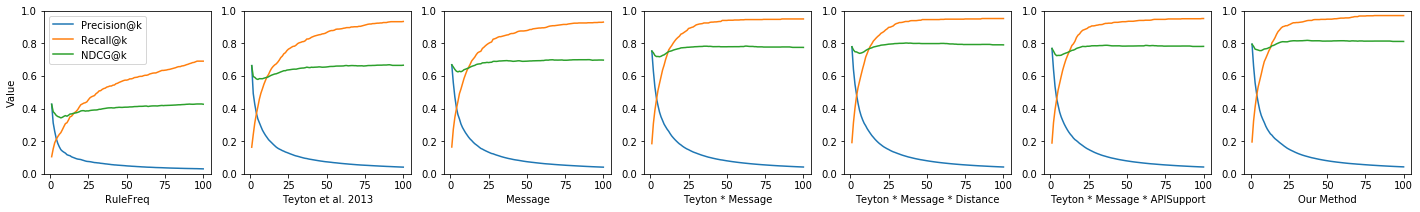

In [19]:
fig, axes = plt.subplots(1, len(methods), figsize=(3.5 * len(methods), 3))
for i, result in enumerate(results):
    x = list(range(1, len(result["Precision-C@k"]) + 1))
    axes[i].plot(x, result["Precision-C@k"], label="Precision@k")
    axes[i].plot(x, result["Recall-C@k"], label="Recall@k")
    axes[i].plot(x, result["NDCG-C@k"], label="NDCG@k")
    axes[i].set_xlabel(result["Name"])
    axes[i].set_ylim([0, 1])
    if i == 0:
        axes[i].set_ylabel("Value")
        axes[i].legend()
fig.show()
fig.savefig("pic/metric-trend.pdf", bbox_inches="tight")

In [12]:
vals = [0.2, 0.4, 0.6, 0.8, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0]
params = []
for loc in range(0, 4):
    for i in vals:
        param = [1, 1, 1, 1]
        param[loc] = i
        params.append((str(param), method, param))
pool = multiprocessing.Pool(12)
results = pool.starmap(parallel_worker, params)
pool.close()
for result in results:
    print_one_line_evaluation_result(result)

[0.2, 1, 1, 1]                : Precision@1 = 0.763, MRR = 0.836, Recall@5 = 0.514, Recall@10 = 0.682, Recall@20 = 0.832, NDCG@10 = 0.735
[0.4, 1, 1, 1]                : Precision@1 = 0.784, MRR = 0.850, Recall@5 = 0.525, Recall@10 = 0.691, Recall@20 = 0.846, NDCG@10 = 0.750
[0.6, 1, 1, 1]                : Precision@1 = 0.789, MRR = 0.852, Recall@5 = 0.530, Recall@10 = 0.700, Recall@20 = 0.860, NDCG@10 = 0.756
[0.8, 1, 1, 1]                : Precision@1 = 0.784, MRR = 0.848, Recall@5 = 0.533, Recall@10 = 0.706, Recall@20 = 0.871, NDCG@10 = 0.759
[1.0, 1, 1, 1]                : Precision@1 = 0.784, MRR = 0.848, Recall@5 = 0.533, Recall@10 = 0.708, Recall@20 = 0.881, NDCG@10 = 0.760
[1.5, 1, 1, 1]                : Precision@1 = 0.784, MRR = 0.846, Recall@5 = 0.534, Recall@10 = 0.713, Recall@20 = 0.877, NDCG@10 = 0.760
[2.0, 1, 1, 1]                : Precision@1 = 0.779, MRR = 0.843, Recall@5 = 0.532, Recall@10 = 0.712, Recall@20 = 0.873, NDCG@10 = 0.758
[2.5, 1, 1, 1]                : Pr